In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
# choose a list of 5 countries to start with abundant data
countries = ['Australia', 'Canada', 'Spain', 'Norway', 'Brazil', 'Germany', 'Chile', 'Argentina', 'India', 'Finland', 'France', 'Sweden', 'Japan', 'Netherlands']

In [3]:
def compute_percent_change_features(country_list, start_date, train_date, test_date):
    def percent_change(new, original):
        return (new - original) / original
    
    # store dataframes in lists
    df_list = []

    for country in countries:
        country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
        # check if there's no organizations, if so use number of occurences of country as backup
        for index, orgs in enumerate(country_df['Country Specific Orgs']):
            if orgs == 0:
                country_df.at[index, 'Country Specific Orgs'] = str(country_df.at[index, 'Addresses']).count(country)
        
        country_df = country_df.drop(columns=['Country Specific Authors'])
        country_df = country_df[country_df['Country Specific Orgs'] > 0]
        country_df = country_df.reset_index(drop=True)

        # get papers from 1998 and onwards
        country_df = country_df[country_df['Publication Year'] >= 1998]
        country_df = country_df.reset_index(drop=True)
        df_list.append(country_df)

    country_train = []
    country_test = []

    for country_data in df_list:
        train_data = pd.DataFrame(dict({'Year': np.zeros(train_date - 1998 + 1), 'Paper Volume': np.zeros(train_date - 1998 + 1), 'Mean Adj. Citations': np.zeros(train_date - 1998 + 1), 'Mean Orgs': np.zeros(train_date - 1998 + 1)}))
        test_data = pd.DataFrame(dict({'Year': np.zeros(test_date - train_date + 1), 'Paper Volume': np.zeros(test_date - train_date + 1), 'Mean Adj. Citations': np.zeros(test_date - train_date + 1), 'Mean Orgs': np.zeros(test_date - train_date + 1)}))
        for date in range(1998, test_date + 1):
            year_data = country_data[country_data['Publication Year'] == date]
            year_data = year_data.reset_index(drop=True)

            if date < train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            elif date == train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            else:
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]

        country_train.append(train_data)
        country_test.append(test_data)
    
    protected_df = pd.read_csv('protected_land_cleaned.csv')
    
    # now compute the percent changes starting from start_date (i.e. can start analysis in start_date + 1)
    
    percent_change_train = []
    percent_change_test = []
    percent_change_protected_test = []
    percent_change_protected_train = []

    for train_df in country_train:
        percent_train = pd.DataFrame(dict({'Change Volume': np.zeros(train_date - start_date), 'Change Citations': np.zeros(train_date - start_date), 'Change Orgs': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            percent_train.iloc[i] = [percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Paper Volume'], train_df.iloc[start_date - 1998 + i]['Paper Volume']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Adj. Citations'], train_df.iloc[start_date - 1998 + i]['Mean Adj. Citations']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Orgs'], train_df.iloc[start_date - 1998 + i]['Mean Orgs'])]
        percent_change_train.append(percent_train)

    for test_df in country_test:    
        percent_test = pd.DataFrame(dict({'Change Volume': np.zeros(test_date - train_date), 'Change Citations': np.zeros(test_date - train_date), 'Change Orgs': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            percent_test.iloc[i] = [percent_change(test_df.iloc[1 + i]['Paper Volume'], test_df.iloc[i]['Paper Volume']), percent_change(test_df.iloc[1 + i]['Mean Adj. Citations'], test_df.iloc[i]['Mean Adj. Citations']), percent_change(test_df.iloc[1 + i]['Mean Orgs'], test_df.iloc[i]['Mean Orgs'])]
        percent_change_test.append(percent_test)

    for country in countries:
        country_protected = protected_df[protected_df['Country'] == country]
        country_protected = country_protected[country_protected['Year'] >= start_date]
        country_protected = country_protected[country_protected['Year'] <= test_date]
        country_protected = country_protected.reset_index(drop=True)

        protect_change_train = pd.DataFrame(dict({'Change Protected Percent': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            protect_change_train.iloc[i] = [percent_change(country_protected.iloc[1 + i]['Value'], country_protected.iloc[0 + i]['Value'])]
        percent_change_protected_train.append(protect_change_train)

        protect_change_test = pd.DataFrame(dict({'Change Protected Percent': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            protect_change_test.iloc[i] = [percent_change(country_protected.iloc[train_date - start_date + 1 + i]['Value'], country_protected.iloc[train_date - start_date + i]['Value'])]
        percent_change_protected_test.append(protect_change_test)
        
    return percent_change_train, percent_change_test, percent_change_protected_train, percent_change_protected_test

In [4]:
X_train_list, X_test_list, y_train_list, y_test_list = compute_percent_change_features(countries, 2000, 2016, 2021)

<ipython-input-3-838c2ed21c5f>:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
<ipython-input-3-838c2ed21c5f>:9: DtypeWarning: Columns (11,15,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
<ipython-input-3-838c2ed21c5f>:9: DtypeWarning: Columns (15,50) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
<ipython-input-3-838c2ed21c5f>:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
<ipython-input-3-838c2ed21c5f>:9: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biod

In [5]:
X_train_list[0]

,Change Volume,Change Citations,Change Orgs
0,0.377358,-0.697482,-0.149511
1,0.273973,0.400608,0.097648
2,0.258065,-0.074747,0.072153
3,0.102564,0.930533,-0.069567
4,0.069767,-0.476985,0.017263
5,0.166667,1.355956,0.059018
6,0.590062,-0.362556,0.110413
7,-0.078125,0.074822,-0.368352
8,0.627119,-0.243324,-0.011810
9,0.177083,0.272235,0.032638


In [6]:
X_test_list[0]

,Change Volume,Change Citations,Change Orgs
0,0.150510,-0.087130,0.007059
1,0.099778,-0.200597,0.010576
2,0.049395,-0.259792,0.024860
3,0.015370,-0.351326,0.021913
4,0.188269,-0.730890,0.029181


In [7]:
def calc_MSE(y_pred, y_true):
    return (1/len(y_pred))*sum(((np.array(y_pred)-np.array(y_true))**2))[0]

In [8]:
# build a simple Linear Regression Model for Country 0 (Australia)

regr = LinearRegression()
regr = regr.fit(X_train_list[0], y_train_list[0])

# get MSE on the test set
calc_MSE(regr.predict(X_test_list[0]), y_test_list[0])

0.0031537626571247245

In [9]:
regr.predict(X_test_list[3])

array([[0.07298204],
       [0.07866962],
       [0.06046016],
       [0.06269829],
       [0.06518485]])

In [10]:
y_test_list[3]

,Change Protected Percent
0,0.010491
1,0.048655
2,0.007482
3,0.000000
4,0.000000


In [11]:
regr.coef_[0]

array([ 2.01071183e-02, -1.42135338e-04,  1.80417051e-01])

In [12]:
from sklearn.preprocessing import PolynomialFeatures

# choose polynomial order than minimizes MSE on test set
degrees = list(range(1, 11))

for degree in degrees:
    # polynomial feature transform
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train_list[1])
    X_poly_test = poly.transform(X_test_list[1])

    # fit a model with the new polynomial features
    poly_regr = LinearRegression()
    poly_regr = poly_regr.fit(X_poly_train, y_train_list[1])

    # get MSE on test set
    print(f'MSE of Degree {degree} polynomial: {calc_MSE(poly_regr.predict(X_poly_test), y_test_list[1])}')

MSE of Degree 1 polynomial: 0.0002431015541504394
MSE of Degree 2 polynomial: 0.001628661255866983
MSE of Degree 3 polynomial: 0.029645688682994737
MSE of Degree 4 polynomial: 0.00849295062827427
MSE of Degree 5 polynomial: 0.01351987953021274
MSE of Degree 6 polynomial: 0.010853423043149556
MSE of Degree 7 polynomial: 0.012203811433279955
MSE of Degree 8 polynomial: 0.011433054379523291
MSE of Degree 9 polynomial: 0.011792801209663082
MSE of Degree 10 polynomial: 0.011543621236260682


In [13]:
def shift_data(shift, X_train_list, X_test_list, y_train_list, y_test_list):
    X_shifted_train_list = []
    X_shifted_test_list = []
    y_shifted_train_list = []
    y_shifted_test_list = []
    
    for index, df in enumerate(X_train_list):
        X_shifted = X_train_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_train_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change Volume Prev {shift_i + 1}', f'Change Citations Prev {shift_i + 1}', f'Change Orgs Prev {shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_train_list.append(X_shifted)
        y_shifted_train_list.append(y_train_list[index][shift:])
    
    for index, df in enumerate(X_test_list):
        X_shifted = X_test_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_test_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change Volume Prev {shift_i + 1}', f'Change Citations Prev {shift_i + 1}', f'Change Orgs Prev {shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_test_list.append(X_shifted)
        y_shifted_test_list.append(y_test_list[index][shift:])
    
    return X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list

In [14]:
X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list = shift_data(3, X_train_list, X_test_list, y_train_list, y_test_list)

In [15]:
# Ridge and Lasso Regression on shifted data
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

ridge_regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_shifted_train_list[0], y_shifted_train_list[0])
lasso_regr = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_shifted_train_list[0], y_shifted_train_list[0])

# get MSE on the test set
print(f'Ridge MSE: {calc_MSE(ridge_regr.predict(X_shifted_test_list[0]), y_shifted_test_list[0])}')
print(f'Lasso MSE: {calc_MSE(lasso_regr.predict(X_shifted_test_list[0]), y_shifted_test_list[0])}')


Ridge MSE: 0.0023613042365475626
Lasso MSE: 0.0019458954790942586


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
degrees = list(range(1, 5))

for degree in degrees:
    # polynomial feature transform
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_shifted_train_list[0])
    X_poly_test = poly.transform(X_shifted_test_list[0])

    # fit a model with the new polynomial features
    poly_regr = LassoCV(alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], max_iter=100000)
    poly_regr = poly_regr.fit(X_poly_train, np.ravel(y_shifted_train_list[0]))

    # get MSE on test set
    print(f'MSE of Degree {degree} polynomial: {calc_MSE(poly_regr.predict(X_poly_test), y_shifted_test_list[0])}')

MSE of Degree 1 polynomial: 0.0019458954790942586
MSE of Degree 2 polynomial: 0.0019458954790942586
MSE of Degree 3 polynomial: 0.0019893683997272045
MSE of Degree 4 polynomial: 0.0021012281580696287


In [17]:
poly_regr.coef_

array([ 0.,  0., -0., ..., -0., -0.,  0.])

In [18]:
ridge_regr.coef_[0]

array([ 0.00213685, -0.00521177,  0.00159219, -0.00349415,  0.00205567,
        0.00077046, -0.0007771 , -0.00633288,  0.00083498,  0.0005515 ,
        0.00386101, -0.00033607])

In [19]:
lasso_regr.predict(X_shifted_test_list[3])

array([0.06125087, 0.06125087])

In [20]:
X_shifted_train_list[0]

,Change Volume,Change Citations,Change Orgs,Change Volume Prev 1,Change Citations Prev 1,Change Orgs Prev 1,Change Volume Prev 2,Change Citations Prev 2,Change Orgs Prev 2,Change Volume Prev 3,Change Citations Prev 3,Change Orgs Prev 3
3,0.102564,0.930533,-0.069567,0.258065,-0.074747,0.072153,0.273973,0.400608,0.097648,0.377358,-0.697482,-0.149511
4,0.069767,-0.476985,0.017263,0.102564,0.930533,-0.069567,0.258065,-0.074747,0.072153,0.273973,0.400608,0.097648
5,0.166667,1.355956,0.059018,0.069767,-0.476985,0.017263,0.102564,0.930533,-0.069567,0.258065,-0.074747,0.072153
6,0.590062,-0.362556,0.110413,0.166667,1.355956,0.059018,0.069767,-0.476985,0.017263,0.102564,0.930533,-0.069567
7,-0.078125,0.074822,-0.368352,0.590062,-0.362556,0.110413,0.166667,1.355956,0.059018,0.069767,-0.476985,0.017263
8,0.627119,-0.243324,-0.011810,-0.078125,0.074822,-0.368352,0.590062,-0.362556,0.110413,0.166667,1.355956,0.059018
9,0.177083,0.272235,0.032638,0.627119,-0.243324,-0.011810,-0.078125,0.074822,-0.368352,0.590062,-0.362556,0.110413
10,0.044248,-0.038446,0.087197,0.177083,0.272235,0.032638,0.627119,-0.243324,-0.011810,-0.078125,0.074822,-0.368352
11,0.129237,0.133113,0.045681,0.044248,-0.038446,0.087197,0.177083,0.272235,0.032638,0.627119,-0.243324,-0.011810
12,0.157598,0.000193,-0.079020,0.129237,0.133113,0.045681,0.044248,-0.038446,0.087197,0.177083,0.272235,0.032638


In [21]:
# run lasso regression over each country, compute the mean model and then measure performance

coef_df = pd.DataFrame(dict({'Coef_1': np.zeros(len(X_shifted_train_list)), 'Coef_2': np.zeros(len(X_shifted_train_list)),
                            'Coef_3': np.zeros(len(X_shifted_train_list)), 'Coef_4': np.zeros(len(X_shifted_train_list)),
                            'Coef_5': np.zeros(len(X_shifted_train_list)), 'Coef_6': np.zeros(len(X_shifted_train_list)),
                            'Coef_7': np.zeros(len(X_shifted_train_list)), 'Coef_8': np.zeros(len(X_shifted_train_list)),
                            'Coef_9': np.zeros(len(X_shifted_train_list)), 'Coef_10': np.zeros(len(X_shifted_train_list)),
                            'Coef_11': np.zeros(len(X_shifted_train_list)), 'Coef_12': np.zeros(len(X_shifted_train_list)),
                            'intercept': np.zeros(len(X_shifted_train_list))}))

for i in range(len(X_shifted_train_list)):
    lasso_regr = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], max_iter=100000).fit(X_shifted_train_list[i], np.ravel(y_shifted_train_list[i]))
    coef_df.iloc[i] = [lasso_regr.coef_[0], lasso_regr.coef_[1], lasso_regr.coef_[2], lasso_regr.coef_[3],
                      lasso_regr.coef_[4], lasso_regr.coef_[5], lasso_regr.coef_[6], lasso_regr.coef_[7],
                      lasso_regr.coef_[8], lasso_regr.coef_[9], lasso_regr.coef_[10], lasso_regr.coef_[11],
                      lasso_regr.intercept_]

coef_df.mean()

Coef_1       0.000000
Coef_2       0.003332
Coef_3       0.000000
Coef_4       0.000123
Coef_5       0.005639
Coef_6       0.000000
Coef_7       0.000313
Coef_8       0.000976
Coef_9       0.000000
Coef_10      0.000294
Coef_11      0.003275
Coef_12      0.000000
intercept    0.028143
dtype: float64

In [22]:
def linear_pred(mean_coefs, X_shifted_test):
    pred = 0
    for index, coef in enumerate(mean_coefs):
        if index < len(mean_coefs) - 1:
            pred += coef * X_shifted_test[index]
        else:
            # intercept
            pred += coef
    return pred

In [23]:
# test performance of mean model, calculating MSE for each country
for i in range(len(X_shifted_test_list)):
    preds = [linear_pred(np.array(coef_df.mean()), X_shifted_test_list[i].iloc[index]) for index in range(len(X_shifted_test_list[i]))]
    print(f'MSE for {countries[i]} is {calc_MSE(preds, y_shifted_test_list[i])}')

MSE for Australia is 0.0006105865325438684
MSE for Canada is 0.00033343191169346516
MSE for Spain is 0.0006453063602849499
MSE for Norway is 0.000644492119309204
MSE for Brazil is 0.0006517038858403306
MSE for Germany is 0.0006459340260071227
MSE for Chile is 0.0007247159090547361
MSE for Argentina is 0.000646950540778417
MSE for India is 0.0007514550551949643
MSE for Finland is 0.0006644785653261258
MSE for France is 0.0006351448270646828
MSE for Sweden is 0.0006363568087099228
MSE for Japan is 0.0007003150208264951
MSE for Netherlands is 0.0006213368397329903


In [24]:
protected_df = pd.read_csv('protected_land_cleaned.csv')
for country in protected_df['Country'].unique():
    country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
    print(f'{country}: {len(country_df)}')

<ipython-input-24-920afeae8b12>:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Australia: 11732
Austria: 2655
Belgium: 3571


<ipython-input-24-920afeae8b12>:3: DtypeWarning: Columns (11,15,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Canada: 8948
Czech Republic: 2950
Denmark: 2929
Finland: 3219


<ipython-input-24-920afeae8b12>:3: DtypeWarning: Columns (6,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


France: 12297


<ipython-input-24-920afeae8b12>:3: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Germany: 15375
Greece: 1289
Hungary: 1259
Iceland: 133
Ireland: 1235


<ipython-input-24-920afeae8b12>:3: DtypeWarning: Columns (11,15,50,53) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Italy: 8982
Japan: 3851
Korea: 1482
Luxembourg: 173
Mexico: 4279
Netherlands: 5985
New Zealand: 2684
Norway: 2321
Poland: 3265
Portugal: 3255
Slovak Republic: 0


<ipython-input-24-920afeae8b12>:3: DtypeWarning: Columns (15,50) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')


Spain: 8957
Sweden: 4920
Switzerland: 5764
United Kingdom: 19
United States: 10


FileNotFoundError: [Errno 2] No such file or directory: 'G7_biodiversity_research.csv'

In [49]:
Australia = pd.read_csv('Australia_biodiversity_research.csv')
Australia

<ipython-input-49-ace81dc439a0>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  Australia = pd.read_csv('Australia_biodiversity_research.csv')


,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Publication Type,Authors,Book Authors,Book Editors,Book Group Authors,Author Full Names,...,WoS Categories,Web of Science Index,Research Areas,IDS Number,UT (Unique WOS ID),Open Access Designations,Paper Age,Adjusted Citations,Country Specific Authors,Country Specific Orgs
0,0,0,0,5,J,"Sutherland, WJ; Freckleton, RP; Godfray, HCJ; ...",NaN,NaN,NaN,"Sutherland, William J.; Freckleton, Robert P.;...",...,Plant Sciences; Ecology,Science Citation Index Expanded (SCI-EXPANDED),Plant Sciences; Environmental Sciences & Ecology,130MQ,WOS:000317922200008,"Green Accepted, Green Submitted",9.0,15.049763,1,1
1,1,1,1,6,J,"Lindenmayer, DB; Franklin, JF; Fischer, J",NaN,NaN,NaN,"Lindenmayer, D. B.; Franklin, J. F.; Fischer, J.",...,Biodiversity Conservation; Ecology; Environmen...,Science Citation Index Expanded (SCI-EXPANDED),Biodiversity & Conservation; Environmental Sci...,065DK,WOS:000239139400008,NaN,16.0,7.862311,0,0
2,2,2,2,35,J,"Wortley, L; Hero, JM; Howes, M",NaN,NaN,NaN,"Wortley, Liana; Hero, Jean-Marc; Howes, Michael",...,Ecology,Science Citation Index Expanded (SCI-EXPANDED)...,Environmental Sciences & Ecology,209DN,WOS:000323734500003,NaN,9.0,14.450297,2,1
3,3,3,3,43,J,"Mac Nally, R",NaN,NaN,NaN,"Mac Nally, R",...,Biodiversity Conservation; Ecology; Environmen...,Science Citation Index Expanded (SCI-EXPANDED),Biodiversity & Conservation; Environmental Sci...,572ZK,WOS:000176804700005,NaN,20.0,5.157662,0,0
4,4,4,4,45,J,"Fischer, J; Brosi, B; Daily, GC; Ehrlich, PR; ...",NaN,NaN,NaN,"Fischer, Joern; Brosi, Berry; Daily, Gretchen ...",...,Ecology; Environmental Sciences,Science Citation Index Expanded (SCI-EXPANDED),Environmental Sciences & Ecology,349UE,WOS:000259308000020,NaN,14.0,8.969476,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11727,11727,11727,11727,150275,B,"Gu, BJ; Zhang, XM",NaN,"Liu, X; Du, E",NaN,"Gu, Baojing; Zhang, Xiuming",...,"Environmental Sciences; Public, Environmental ...",Book Citation Index – Science (BKCI-S),"Environmental Sciences & Ecology; Public, Envi...",BP6AA,WOS:000558698900007,NaN,2.0,0.120027,0,0
11728,11728,11728,11728,150279,J,"Haque, MM; Beaumont, LJ; Nipperess, DA",NaN,NaN,NaN,"Haque, Md. Mohasinul; Beaumont, Linda J.; Nipp...",...,Biodiversity Conservation; Ecology; Environmen...,Science Citation Index Expanded (SCI-EXPANDED),Biodiversity & Conservation; Environmental Sci...,KJ2CQ,WOS:000511866200018,NaN,2.0,0.120027,0,0
11729,11729,11729,11729,150297,J,"Kuzmic, F; Silc, U; Lososova, Z; Mucina, L; Ch...",NaN,NaN,NaN,"Kuzmic, Filip; Silc, Urban; Lososova, Zdenka; ...",...,Plant Sciences; Ecology,Science Citation Index Expanded (SCI-EXPANDED),Plant Sciences; Environmental Sciences & Ecology,LF7XV,WOS:000527630700005,NaN,2.0,0.120027,1,1
11730,11730,11730,11730,150299,J,"Lamichhane, JR; You, MP; Barbetti, MJ; Auberto...",NaN,NaN,NaN,"Lamichhane, Jay Ram; You, Ming Pei; Barbetti, ...",...,Plant Sciences; Microbiology,Science Citation Index Expanded (SCI-EXPANDED),Plant Sciences; Microbiology,OS2DH,WOS:000589975800004,NaN,2.0,0.120027,2,1


In [39]:
data = y_train_list[5].to_numpy()
data = data.flatten()
data

array([0.09036029, 0.01598289, 0.02580106, 0.16045833, 0.03188623,
       0.04231987, 0.07577736, 0.04209903, 0.00959627, 0.00569301,
       0.00751233, 0.00700548, 0.00912548, 0.00731914, 0.00412207,
       0.01771343])

In [43]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt


data = y_train_list[5].to_numpy()
data = data.flatten()  # A list of response value with a constant time interval
train, test = model_selection.train_test_split(data, train_size=0.5)

In [ ]:
temp = pm.datasets.load_wineind()

[0.09036029 0.01598289 0.02580106 0.16045833 0.03188623 0.04231987
 0.07577736 0.04209903 0.00959627 0.00569301 0.00751233 0.00700548]
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=-6.426, Time=0.02 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=-21.475, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=-21.557, Time=0.02 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=-10.422, Time=0.02 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=-23.293, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[2] intercept   : AIC=-23.094, Time=0.01 sec
 ARIMA(0,0,0)(0,1,1)[2] intercept   : AIC=-18.043, Time=0.01 sec
 ARIMA(0,0,0)(1,1,1)[2] intercept   : AIC=-20.895, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=-20.193, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[2] intercept   : AIC=-11.869, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[2] intercept   : AIC=-10.410, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,1,0)[2]          
Total fit time: 0.158 seconds


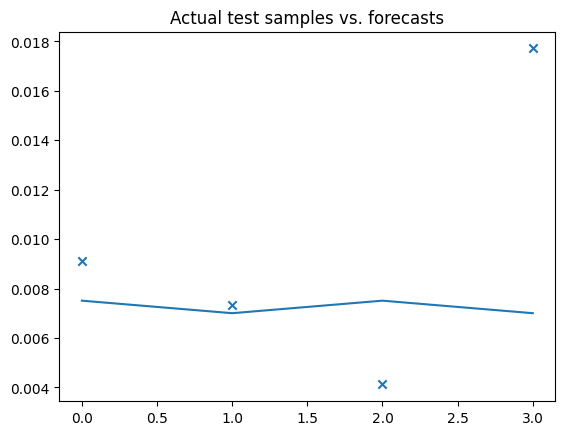

In [48]:

print(train)

arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=1,
                      seasonal=True, m=2)


x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.style.use('default')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-5.070, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-9.557, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-7.008, Time=0.16 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-7.557, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-7.557, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-5.557, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-8.598, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-9.008, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-7.068, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-7.559, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.184 seconds


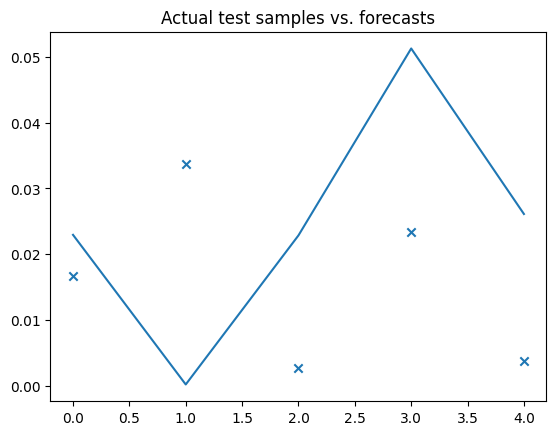

In [56]:
data = y_train_list[5].to_numpy()
data = data.flatten()  # A list of response value with a constant time interval
train, test = model_selection.train_test_split(data, train_size=0.7)
model = pm.auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
x = np.arange(test.shape[0])
plt.scatter(x, test, marker='x')
plt.plot(x, model.predict(n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.style.use('default')
plt.show()

In [70]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state = 0, n_estimators= 10)
regr.fit(X_train_list[0], y_train_list[0])
regr.predict(X_test_list[0])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.05027094, 0.0621504 , 0.0621504 , 0.04077821, 0.02532455])

In [71]:
X_test_list[0]

,Change Volume,Change Citations,Change Orgs
0,0.150510,-0.087130,0.007059
1,0.099778,-0.200597,0.010576
2,0.049395,-0.259792,0.024860
3,0.015370,-0.351326,0.021913
4,0.188269,-0.730890,0.029181


In [72]:
from sklearn.metrics import mean_squared_error
y_pred = regr.predict(X_test_list[0])
mean_squared_error(y_test_list[0], y_pred)

0.0018310597633469055